In [9]:
import json
import pandas
import numpy as np
from pathlib import Path

import pandas as pd
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

In [8]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

In [4]:
pl.seed_everything(42)

Global seed set to 42


42

In [12]:
df = pd.read_csv('data/news_summary.csv', encoding="latin-1")
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [15]:
df = df[["text", "ctext"]]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [17]:
df.columns = ["summary", "text"]
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [18]:
df.shape

(4396, 2)

In [19]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

((3956, 2), (440, 2))

In [20]:
class NewsSummaryDataset(Dataset):

    def __init__(
            self,
            data: pd.DataFrame,
            tokenizer: T5Tokenizer,
            text_max_token_len: int = 512,
            summary_max_token_len: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row['text']

        text_encoding = self.tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        summary_encoding = self.tokenizer(
            data_row['summary'],
            max_length=self.summary_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100

        return dict(
            text=text,
            summary_encoding=data_row['summary'],
            text_input_ids=text_encoding['input_ids'].flatten(),
            text_attention_mask=text_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=summary_encoding["attention_mask"].flatten()
        )

In [22]:
class NewsSummaryDataModule(pl.LightningDataModule):

    def __init__(
            self,
            train_df: pd.DataFrame,
            test_df: pd.DataFrame,
            tokenizer: T5Tokenizer,
            batch_size: int = 8,
            text_max_token_len: int = 512,
            summary_max_token_len: int = 128
    ):

        super().__init__()

        self.train_df = train_df
        self.test_df = test_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len


    def setup(self, stage=None):
        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

In [24]:
MODEL_NAME = "t5-base"

toekenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

/Users/ijinseong/opt/anaconda3/envs/ai/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [29]:
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
    text_token_count = len(toekenizer.encode(row["text"]))
    text_token_counts.append(text_token_count)

    summary_token_count = len(toekenizer.encode(row["summary"]))
    summary_token_counts.append(summary_token_counts)

In [40]:
print(text_token_count)
print(text_token_counts)
print(train_df.iloc[2]['text'])
print(toekenizer.encode(train_df.iloc[2]['text']))

749
[183, 689, 304, 443, 335, 501, 262, 164, 519, 425, 434, 580, 1247, 382, 252, 338, 415, 463, 413, 279, 155, 818, 215, 353, 397, 1364, 750, 531, 358, 1011, 216, 141, 421, 470, 265, 466, 382, 267, 1336, 382, 380, 414, 91, 195, 126, 687, 459, 354, 541, 403, 300, 538, 331, 74, 277, 867, 326, 982, 481, 62, 998, 962, 1794, 195, 883, 277, 200, 487, 274, 267, 210, 158, 436, 493, 300, 277, 286, 196, 246, 273, 417, 172, 1022, 1043, 2069, 260, 319, 291, 314, 447, 170, 176, 222, 623, 1947, 261, 301, 377, 349, 452, 860, 609, 670, 188, 546, 3192, 525, 256, 363, 1191, 278, 6442, 318, 510, 349, 102, 451, 310, 346, 437, 439, 38, 260, 840, 464, 402, 705, 367, 426, 440, 207, 309, 1506, 1398, 405, 894, 246, 417, 162, 498, 462, 786, 746, 505, 640, 877, 375, 2213, 393, 280, 589, 206, 678, 798, 540, 644, 204, 410, 78, 436, 405, 721, 428, 71, 667, 421, 391, 598, 1632, 824, 352, 601, 478, 527, 31, 241, 435, 465, 218, 948, 358, 495, 649, 487, 293, 304, 450, 569, 441, 197, 433, 908, 273, 485, 289, 373, 666, 4

KeyboardInterrupt: 

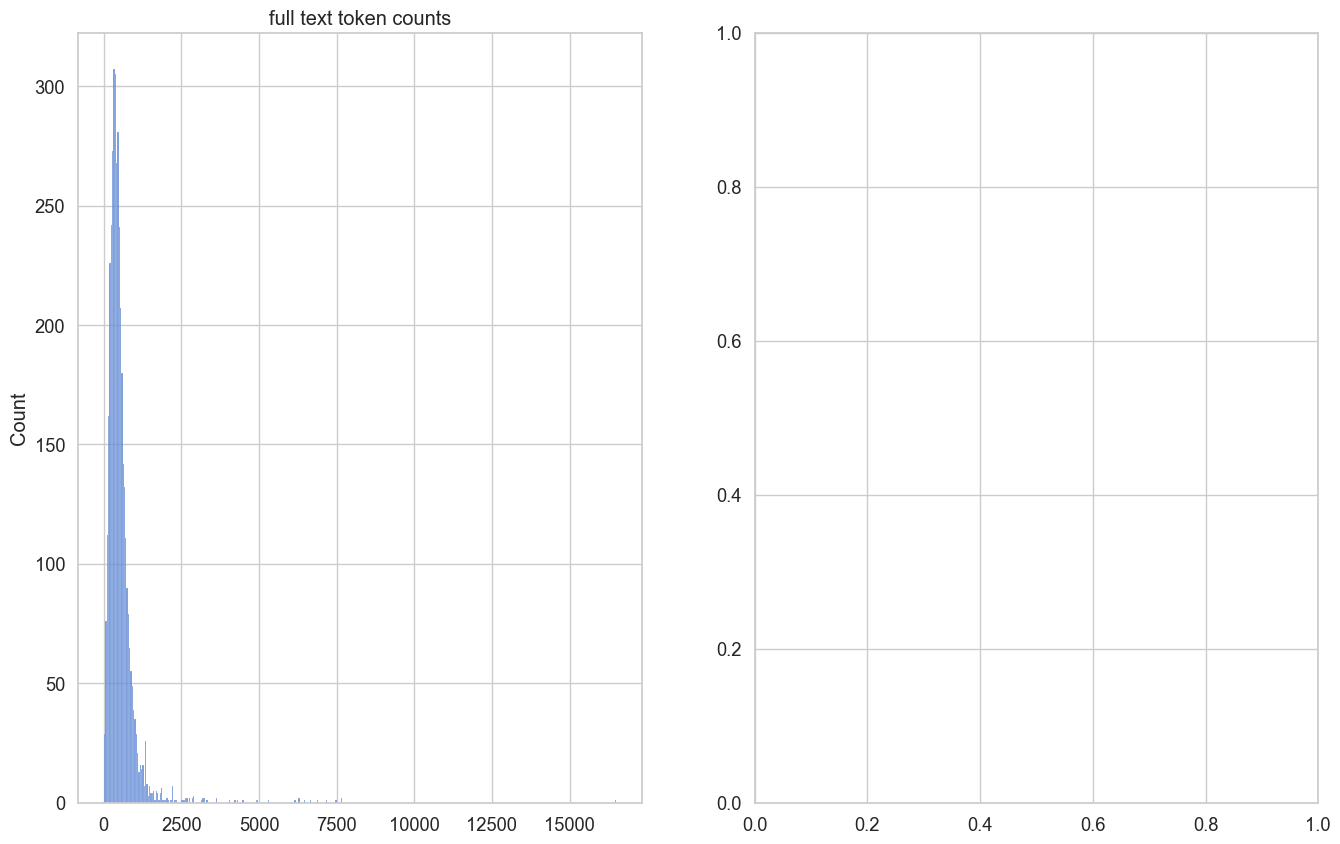

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(text_token_counts, ax=ax1)
ax1.set_title("full text token counts")

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title("summary text token counts")

In [42]:
N_EPOCHS = 3
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df, test_df, toekenizer, batch_size=BATCH_SIZE)

# Model

In [43]:
class NewsSummaryModel(pl.LightningDataModule):

    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):

        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [45]:
model = NewsSummaryModel()

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [47]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Launching TensorBoard...

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [51]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger('lightning_logs', name='news-summary')

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    gpus=1,
    max_epochs=N_EPOCHS,
    progress_bar_refresh_rate=30
)

TypeError: Trainer.__init__() got an unexpected keyword argument 'checkpoint_callback'

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

In [ ]:
def summarize(text):
    text_encoding = toekenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
               )

    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
        toekenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]

    return "".join(preds)

In [ ]:
sample_row = test_df.iloc[0]
text = sample_row['text']
model_summary = summarize(text)

In [ ]:
text

In [ ]:
sample_row['summary']

In [ ]:
model_summary